In [6]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
import re
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [7]:
companies = ['nikesupport','xboxsupport','upshelp','comcastcares','amazonhelp','jetblue','americanair',
             'tacobellteam','mcdonalds','kimpton','ihgservice','spotifycares','hiltonhelp','applesupport',
             'microsofthelps','googleplaymusic','scsupport','pandorasupport','hoteltonightcx','dunkindonuts',
             'jackbox','chipotletweets','askpanera','carlsjr','att','tmobilehelp','sprintcare','verizonsupport',
             'boostcare','uscellularcares','alaskaair','virginamerica','virginatlantic','delta','british_airways',
             'southwestair','awssupport','twittersupport','askplaystation','neweggservice','dropboxsupport',
             'hpsupport','atviassist','azuresupport','nortonsupport','dellcares','hulu_support','askrobinhood',
             'officesupport','arbyscares','pearsonsupport','yahoocare','idea_cares','airtel_care','coxhelp',
             'kfc_uki_help','asurioncares','adobecare','glocare','sizehelpteam','airasiasupport','safaricom_care',
             'oppocarein','bofa_help','chasesupport','askciti','ask_wellsfargo','keybank_help','moo','centurylinkhelp',
             'mediatemplehelp','godaddyhelp','postmates_help','doordash_help','airbnbhelp','uber_support','asklyft',
             'askseagate','ask_spectrum','askpaypal','asksalesforce','askvirginmoney','askdsc','askpapajohns','askrbc',
             'askebay','asktigogh','vmucare','askamex','ask_progressive','mtnc_care','askvisa','tesco','sainsburys',
             'walmart','asktarget','morrisons','aldiuk','argoshelpers','greggsofficial','marksandspencer','virgintrains',
             'nationalrailenq','sw_help','londonmidland','gwrhelp','tfl','o2']

## Functions

## Import Data

In [8]:
df = pd.read_csv('../data/twcs.csv')

## EDA

### Import Pickle

In [15]:
df = pd.read_pickle('../data/tweets.pkl')

### Response Time

Starter code from [Kaggle Dataset](https://www.kaggle.com/soaxelbrooke/first-inbound-and-response-tweets)

In [16]:
# Pick only inbound tweets that aren't in reply to anything...
first_inbound = df[pd.isnull(df.in_response_to_tweet_id) & df.inbound]
print('Found {} first inbound messages.'.format(len(first_inbound)))

Found 622277 first inbound messages.


In [17]:
# Merge in all tweets in response
inbounds_and_outbounds = pd.merge(first_inbound, df, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')
print("Found {} responses.".format(len(inbounds_and_outbounds)))

Found 696125 responses.


In [18]:
# Filter out cases where reply tweet isn't from company
inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]

In [19]:
print("Found {} responses from companies.".format(len(inbounds_and_outbounds)))
print("Tweets Preview:")
print(inbounds_and_outbounds)

Found 630633 responses from companies.
Tweets Preview:
       tweet_id_x author_id_x  inbound_x  \
0               6       95932       True   
1               9       95933       True   
2              13       95934       True   
3              16       95935       True   
5              28       95938       True   
7              40       95940       True   
8              45       95941       True   
9              45       95941       True   
10             51       95943       True   
11             56       95944       True   
12             59       95945       True   
13             61       95946       True   
14             68       95947       True   
15             74       95948       True   
16             76       95949       True   
17             78       95950       True   
18             80       95952       True   
19             92       95957       True   
20             94       95958       True   
21             96       95959       True   
22             98    

In [20]:
inbounds_and_outbounds.head()

,tweet_id_x,author_id_x,inbound_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,date_x,month_x,day_x,time_x,tweet_id_y,author_id_y,inbound_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y,date_y,month_y,day_y,time_y
0,6,95932,True,@VirginAtlantic what's the deal on the nonstop...,5,NaN,2017-10-04 20:05:43,10,2,20:05:43,5,VirginAtlantic,False,@95932 Have you tried towards the end of March...,3,6.0,2017-10-04 20:15:59,10,2,20:15:59
1,9,95933,True,@VirginAtlantic saw your page on upgrading. I ...,7,NaN,2017-10-04 22:28:38,10,2,22:28:38,7,VirginAtlantic,False,@95933 Was this the bid for an upgrade you wer...,8,9.0,2017-10-04 22:36:39,10,2,22:36:39
2,13,95934,True,@VirginAtlantic Any idea why our flight VS7 ca...,11,NaN,2017-10-04 22:31:55,10,2,22:31:55,11,VirginAtlantic,False,@95934 I don't know the reason for the cancell...,12,13.0,2017-10-04 22:35:25,10,2,22:35:25
3,16,95935,True,@AmericanAir Ur shady,14,NaN,2017-10-04 22:35:45,10,2,22:35:45,14,AmericanAir,False,"@95935 We work to keep our customers informed,...",15,16.0,2017-10-04 23:41:28,10,2,23:41:28
5,28,95938,True,@VirginAtlantic Arrived Gatwick this a.m - su...,27,NaN,2017-10-04 22:04:46,10,2,22:04:46,27,VirginAtlantic,False,@95938 Sorry to hear that Kassi. Have you repo...,26,28.0,2017-10-04 22:06:34,10,2,22:06:34


In [ ]:
# Subtract the time_y - time _x

In [ ]:
# take the average response time by company

### Company Groups

In [24]:
companyGroup = df.groupby('author_id').inbound.count().reset_index()
companyGroup = companyGroup.loc[companyGroup.iloc[:,0].str.contains(r'(^\D{6})')]
companyGroup.sort_values('author_id',inplace=True)

/home/xavier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [25]:
companies = list(set(companyGroup.author_id))
companies.sort()

In [27]:
companies

['ATVIAssist',
 'AWSSupport',
 'AdobeCare',
 'AirAsiaSupport',
 'AirbnbHelp',
 'AlaskaAir',
 'AldiUK',
 'AmazonHelp',
 'AmericanAir',
 'AppleSupport',
 'ArbysCares',
 'ArgosHelpers',
 'AskAmex',
 'AskCiti',
 'AskDSC',
 'AskLyft',
 'AskPapaJohns',
 'AskPayPal',
 'AskPlayStation',
 'AskRBC',
 'AskRobinhood',
 'AskSeagate',
 'AskTarget',
 'AskTigogh',
 'AskVirginMoney',
 'Ask_Spectrum',
 'Ask_WellsFargo',
 'AskeBay',
 'AsurionCares',
 'AzureSupport',
 'BofA_Help',
 'BoostCare',
 'British_Airways',
 'CarlsJr',
 'CenturyLinkHelp',
 'ChaseSupport',
 'ChipotleTweets',
 'CoxHelp',
 'DellCares',
 'DoorDash_Help',
 'DropboxSupport',
 'DunkinDonuts',
 'GWRHelp',
 'GloCare',
 'GoDaddyHelp',
 'GooglePlayMusic',
 'GreggsOfficial',
 'HPSupport',
 'HiltonHelp',
 'HotelTonightCX',
 'IHGService',
 'JackBox',
 'JetBlue',
 'KFC_UKI_Help',
 'KeyBank_Help',
 'Kimpton',
 'LondonMidland',
 'MTNC_Care',
 'McDonalds',
 'MicrosoftHelps',
 'Morrisons',
 'NeweggService',
 'NikeSupport',
 'NortonSupport',
 'OPPOCar

In [28]:
df.drop('created_at',axis=1,inplace=True)

In [29]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date
0,1,VirginAtlantic,False,@95932 Hmmm they may be full. Have you tried b...,2,3.0,2017-10-04 22:37:58
1,2,95932,True,@VirginAtlantic Sure have. Nothing comes up at...,4,1.0,2017-10-04 22:55:58
2,4,VirginAtlantic,False,@95932 I'm going to report this then. It sound...,NaN,2.0,2017-10-04 23:00:12
3,3,95932,True,"@VirginAtlantic Yes, nothing comes up 🙁",1,5.0,2017-10-04 22:36:35
4,5,VirginAtlantic,False,@95932 Have you tried towards the end of March...,3,6.0,2017-10-04 20:15:59


### Date Range

In [31]:
df.date.min()

Timestamp('2008-05-08 20:13:59')

In [32]:
df.date.max()

Timestamp('2017-11-21 21:43:02')

In [33]:
df2 = df.sort_values('date',ascending=True)

In [34]:
df2.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month
319047,347379,SouthwestAir,False,@17251 Have FUN at the lecture tonight! Tell...,347364,347380.0,2008-05-08 20:13:59,5
319046,347364,183416,True,@SouthwestAir Can you pls enter the HI market ...,"347365,347366,347363,347367,347368,347369,3473...",347379.0,2008-05-08 21:04:16,5
542908,590641,241659,True,KTAR.com - Foreclosures still big problem in V...,590640,NaN,2010-02-16 15:49:47,2
627162,681789,263054,True,@263056 Do you know if Carl's Jr serves lunch ...,681787,NaN,2010-03-31 15:24:29,3
627160,681787,CarlsJr,False,@263054 We serve lunch all day!,681788,681789.0,2010-03-31 16:53:27,3


### Tweets by Month

In [35]:
df.inbound.value_counts()

True     1214604
False    1011217
Name: inbound, dtype: int64

In [36]:
inboundDF = df[df.inbound == True]

In [37]:
inboundDF.shape

(1214604, 8)

In [38]:
monthGroup = df.groupby('month').inbound.count().reset_index()

In [39]:
monthGroup

,month,inbound
0,1,328
1,2,332
2,3,283
3,4,451
4,5,545
5,6,602
6,7,978
7,8,2158
8,9,13049
9,10,1252961


Text(0,0.5,'Inbound Tweets')

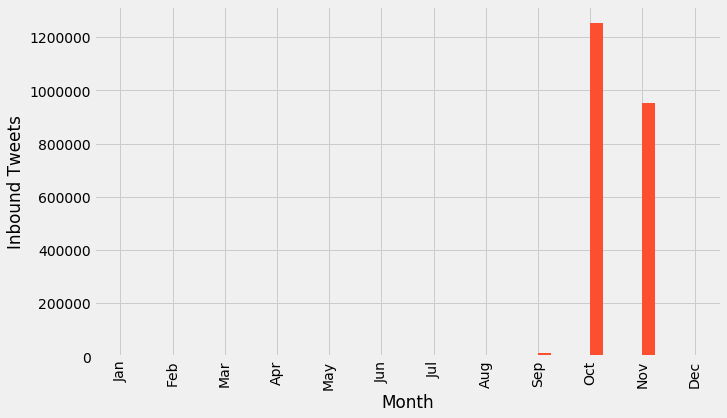

In [40]:
month_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthGroup.plot(kind='bar',figsize=(10,6),legend=False)
plt.xticks(range(12),month_ticks)
plt.xlabel('Month')
plt.ylabel('Inbound Tweets')

### Tweets by Day

In [41]:
df['day'] = df.date.dt.dayofweek

In [42]:
dayGroup = df.groupby('day').inbound.count().reset_index()

Text(0,0.5,'Inbound Tweets')

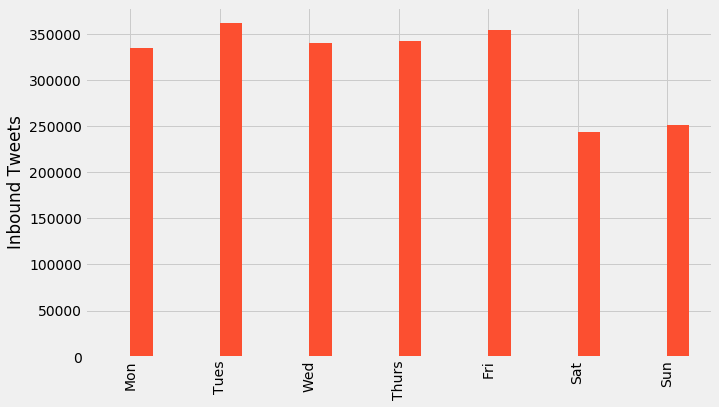

In [43]:
day_ticks = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
dayGroup.plot(kind='bar',figsize=(10,6),legend=False)
plt.xticks(range(7),day_ticks)
#plt.xlabel('Day')
plt.ylabel('Inbound Tweets')

### Tweets by Company

In [44]:
companyGroup = df.groupby('author_id').inbound.count().reset_index()

In [45]:
companyGroup = companyGroup.loc[companyGroup.iloc[:,0].str.contains(r'(^\D{6})')]
companyGroup.sort_values('inbound',ascending=False,inplace=True)

/home/xavier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [46]:
companyGroup.shape

(102, 2)

In [47]:
companyGroup

,author_id,inbound
569050,AmazonHelp,129431
569052,AppleSupport,90432
569127,Uber_Support,42289
569119,SpotifyCares,34328
569051,AmericanAir,29642
569120,TMobileHelp,28644
569141,comcastcares,26270
569075,British_Airways,24395
569118,SouthwestAir,23302
569068,Ask_Spectrum,20961


In [48]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month,day
0,1,VirginAtlantic,False,@95932 Hmmm they may be full. Have you tried b...,2,3.0,2017-10-04 22:37:58,10,2
1,2,95932,True,@VirginAtlantic Sure have. Nothing comes up at...,4,1.0,2017-10-04 22:55:58,10,2
2,4,VirginAtlantic,False,@95932 I'm going to report this then. It sound...,NaN,2.0,2017-10-04 23:00:12,10,2
3,3,95932,True,"@VirginAtlantic Yes, nothing comes up 🙁",1,5.0,2017-10-04 22:36:35,10,2
4,5,VirginAtlantic,False,@95932 Have you tried towards the end of March...,3,6.0,2017-10-04 20:15:59,10,2


In [49]:
appleDF = df[df['author_id'].str.contains("AppleSupport") | df['text'].str.contains("AppleSupport") ]

In [50]:
appleDF.shape

(171517, 9)

In [51]:
appleDF.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month,day
119,129,AppleSupport,False,@95972 Let's take a look at your flashlight to...,130,131.0,2017-10-04 13:04:26,10,2
120,130,95973,True,@AppleSupport @95972 i have the same problem w...,NaN,129.0,2017-10-04 22:10:17,10,2
309,385,AppleSupport,False,@96035 We want you to get the most out of your...,NaN,386.0,2017-10-04 12:33:00,10,2
339,416,AppleSupport,False,"@96041 We appreciate you letting us know, does...",NaN,417.0,2017-10-04 12:59:29,10,2
340,417,96041,True,@AppleSupport When you go to the App Store &am...,416,418.0,2017-10-04 04:57:54,10,2


### Tweets by Conversations

In [52]:
testDF = df[(df['author_id'].str.contains("95972"))]

In [53]:
testDF.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month,day
121,131,95972,True,the update made my fuckin flashlight stop work...,129,NaN,2017-10-04 05:43:36,10,2
366775,398930,195972,True,"@AmazonHelp Si, pero ya no soluciona nada, lo ...",398932,398929.0,2017-10-13 13:12:57,10,4
366777,398933,195972,True,@AmazonHelp No voy a perder más tiempo en esto...,NaN,398932.0,2017-10-13 13:16:54,10,4
366778,398931,195972,True,Gracias por nada @96220 @99212 https://t.co/K2...,398929,NaN,2017-10-13 12:56:40,10,4
758859,701554,295972,True,"@97286 No. Demasiado caro. Lo siento, @97286, ...","822262,822263,822264",701546.0,2017-10-21 17:24:07,10,5


In [54]:
testDF.to_csv('../data/test.csv')